### Метод парзеновского окна для решения задачи классификации вин

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import decomposition, datasets, metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from matplotlib import gridspec

from mlxtend.plotting import plot_decision_regions

In [2]:
#загружаем датасет, нормализуем и делим на обучающую и тестовую выборки
dataset = load_wine()

X = StandardScaler().fit_transform(dataset.data)
Y = dataset.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

#plt.figure(figsize=(3, 3))
#plt.scatter(X_train[:, 0], X_train[:, 1], label="train")
#plt.scatter(X_test[:, 0], X_test[:, 1], label="test")
#plt.legend()

In [3]:
#Вводим функцию для ядра и классификатор
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)
    
def ParzenKNN(neighbors=10, H=0.5):
    return KNeighborsClassifier(n_neighbors=neighbors,
                                 weights=lambda x: K(x, h=H))

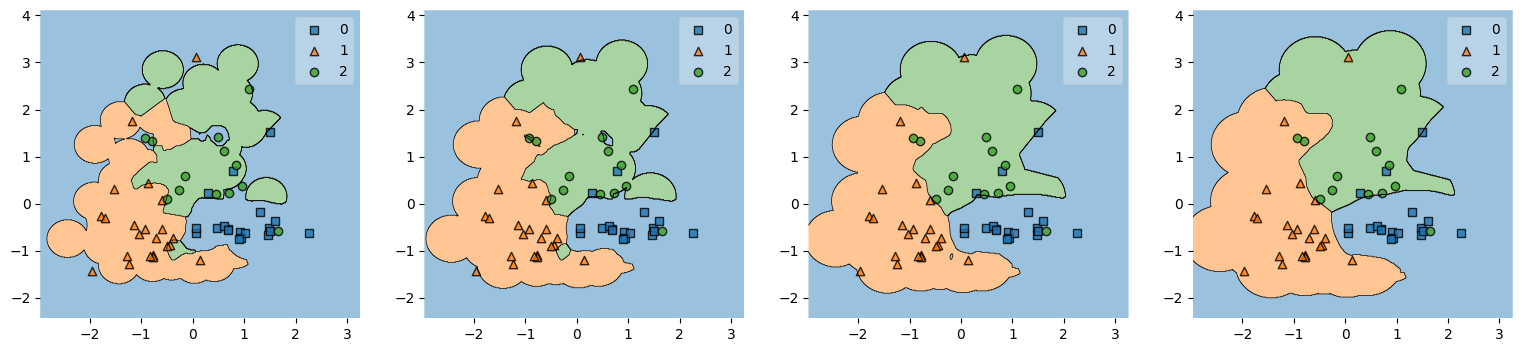

In [4]:
#Обучение по первым двум признакам
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i, h in enumerate([0.4, 0.5, 0.6, 0.7]):
    model = ParzenKNN(neighbors=len(X_train),H=h)
    model.fit(X_train[:,:2], Y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test[:,:2], Y_test, model, ax=ax[i])

plt.show()

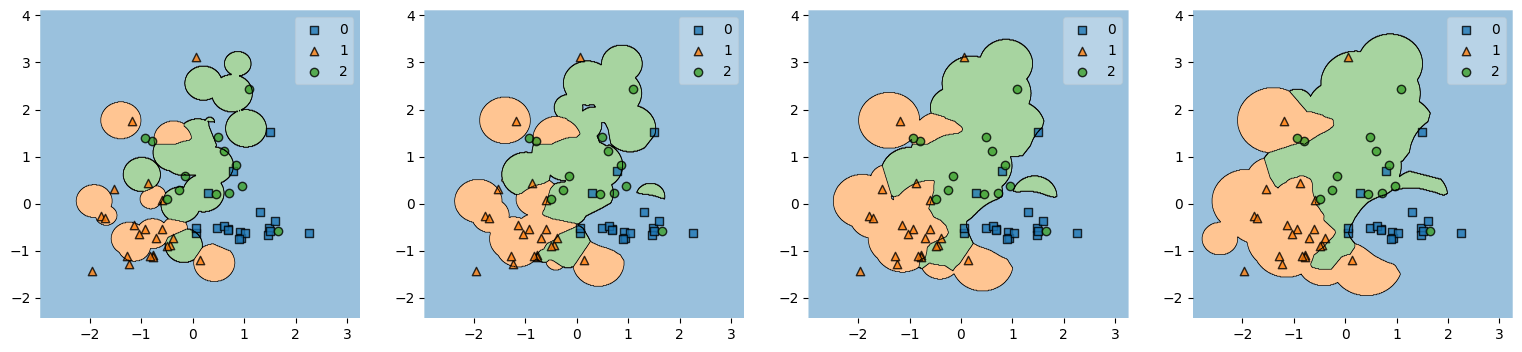

In [5]:
#Обучение по первым трем признакам

value=0
width=10

fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i, h in enumerate([0.4, 0.5, 0.6, 0.7]):
    model = ParzenKNN(neighbors=len(X_train),H=h)
    model.fit(X_train[:,:3], Y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test[:,:3], Y_test, model, ax=ax[i],
                         filler_feature_values={2: value},  #these will be ignored
                          filler_feature_ranges={2: width})

plt.show()

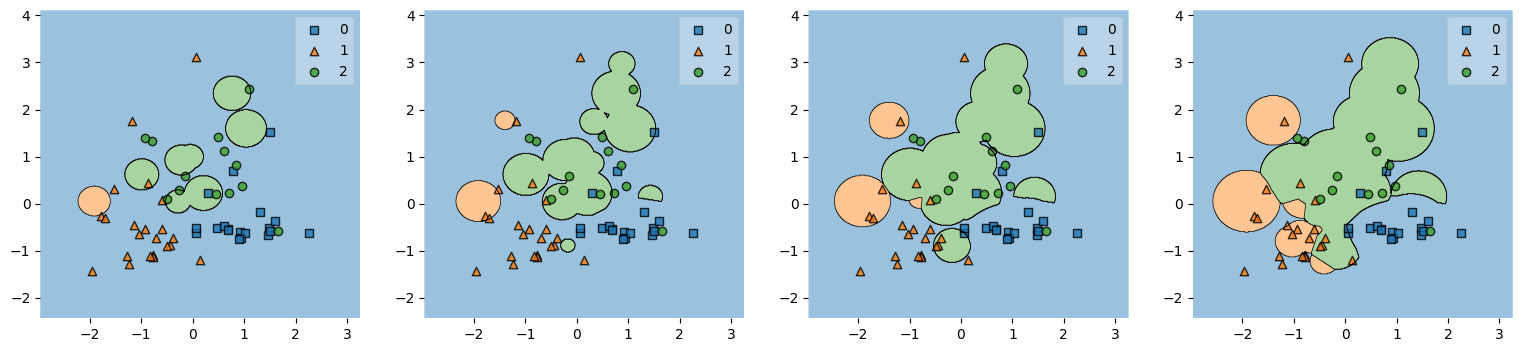

In [6]:
#Обучение по первым пяти признакам

value=0
width=10

fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i, h in enumerate([0.4, 0.5, 0.6, 0.7]):
    model = ParzenKNN(neighbors=len(X_train),H=h)
    model.fit(X_train[:,:4], Y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test[:,:4], Y_test, model, ax=ax[i],
                         filler_feature_values={2:value, 3:value},  
                          filler_feature_ranges={2:width,3:width})

plt.show()

C:\Users\simak\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)
C:\Users\simak\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)
C:\Users\simak\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


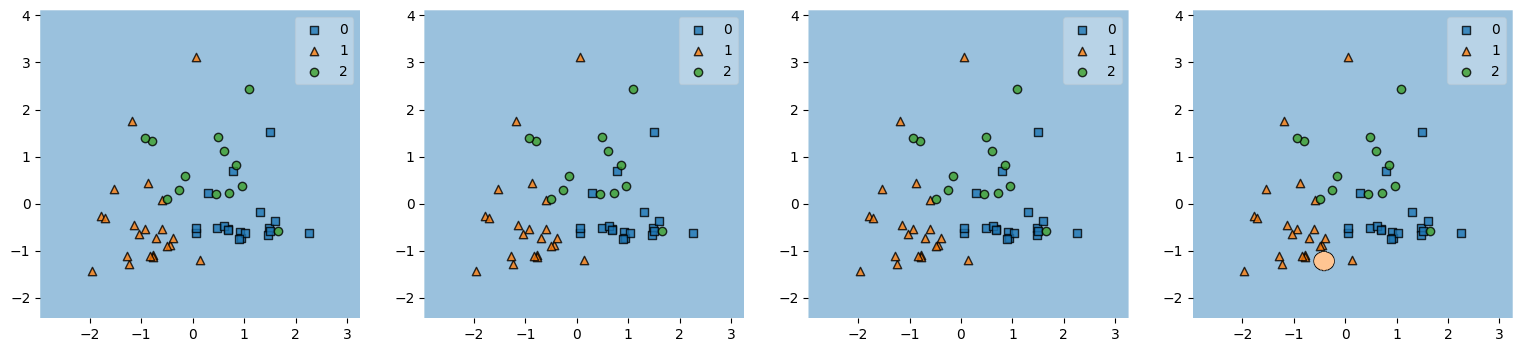

In [7]:
#Обучение по семи признакам

value=0
width=100

fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []
for i, h in enumerate([0.4, 0.5, 0.6, 0.7]):
    model = ParzenKNN(neighbors=len(X_train),H=h)
    model.fit(X_train[:,:7], Y_train)
    ax.append(fig.add_subplot(gs[i]))
    plot_decision_regions(X_test[:,:7], Y_test, model, ax=ax[i],
                         filler_feature_values={2:value,3:value,4:value,5:value,6:value}, #,7:value,8:value,9:value,10:value,11:value,12:value},  
                          filler_feature_ranges={2:width,3:width,4:width,5:width,6:width}) #,7:width,8:width,9:width,10:width,11:width,12:width})

plt.show()

### => нужно убрать часть признаков

In [8]:
#выбираем количество важных признаков

pca = decomposition.PCA()

pipe = Pipeline(steps=[('pca', pca)])
n_components = list(range(1,X.shape[1]+1,1))
parameters = dict(pca__n_components=n_components)

clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X, Y)

print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])

Best Number Of Components: 7


In [9]:
#выбираем важные признаки и удаляем остальные

model_pca = decomposition.PCA(clf_GS.best_estimator_.get_params()['pca__n_components'])
model_pca.fit(X_train)
X_train = model_pca.transform(X_train)
X_test = model_pca.transform(X_test)

In [10]:
#Выбираем оптимальное количество соседей
parzen = KNeighborsClassifier()
params = {
    'n_neighbors': [3, 10, 20],
}

clf_GS = GridSearchCV(parzen, params)
clf_GS.fit(X_train, Y_train)

n = clf_GS.best_estimator_.get_params()['n_neighbors']

print('Best number of neighbors:', n)

Best number of neighbors: 20


In [11]:
#Обучаем модель с полученными гиперпараметрами 

model = ParzenKNN(neighbors=n, H=0.5)

#Оцениваем метрики на тестовой выборке
scores = []
model.fit(X_train, Y_train)
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.35      1.00      0.52        19
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        13

    accuracy                           0.35        54
   macro avg       0.12      0.33      0.17        54
weighted avg       0.12      0.35      0.18        54



C:\Users\simak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [12]:
### => нужно еще понизить размерность

In [13]:
#выбираем важные признаки и удаляем остальные

model_pca = decomposition.PCA(2)
model_pca.fit(X_train)
X_train = model_pca.transform(X_train)
X_test = model_pca.transform(X_test)

In [14]:
#Обучаем модель с полученными гиперпараметрами 

model = ParzenKNN(neighbors=n, H=0.5)

#Оцениваем метрики на тестовой выборке
scores = []
model.fit(X_train, Y_train)
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93        19
           1       1.00      0.91      0.95        22
           2       1.00      0.92      0.96        13

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.95        54
weighted avg       0.95      0.94      0.95        54



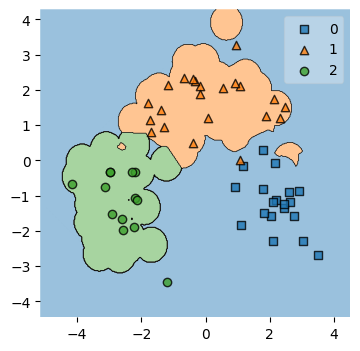

In [17]:
#визуализация

fig = plt.figure(figsize=(4,4))

plot_decision_regions(X_test, Y_test, model) 
plt.show()